In [1]:
# imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\janbb\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# string to int and int to string mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset given words and context length
def build_dataset(words, block_size):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for character in word + '.':
            index = stoi[character]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [5]:
# divide into training set (80%), validation/dev set (10%) and test set (10%)
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

context_length = 3
X_train, Y_train = build_dataset(words[:n1], context_length)
X_dev, Y_dev = build_dataset(words[n1:n2], context_length)
X_test, Y_test = build_dataset(words[n2:], context_length)
X_train[:5], Y_train[:5]

(tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         [25, 21,  8],
         [21,  8,  5]]),
 tensor([25, 21,  8,  5, 14]))

In [6]:
g = torch.Generator().manual_seed(2147483647)
# 10-dimensional vector space for letters
dim = 10
C = torch.randn((27, dim), generator=g)
# first layer that is hidden
weights1 = torch.randn((dim * context_length, 200), generator=g)
bias1 = torch.randn(200, generator=g)
# output layer
weights2 = torch.randn((200, 27), generator=g)
bias2 = torch.randn(27, generator=g)
# all parametters
parameters = [C, weights1, bias1, weights2, bias2]

In [7]:
sum(p.nelement() for p in parameters) # number of parameters

11897

In [8]:
# turning gradient on
for p in parameters:
    p.requires_grad = True

In [9]:
steps = []
log_loss = [] 

In [10]:
for i in range(200000):
    # getting minibatch
    index = torch.randint(0, X_train.shape[0], (32,)) 

    # forward pass
    embedings = C[X_train[index]]               # (32, 3, 10)
    hidden_layer = torch.tanh(embedings.view(-1, dim * context_length) @ weights1 + bias1) # .view "connects" 3 x 10 dim = 30 -> (32, 200)
    logits = hidden_layer @ weights2 + bias2    # (32, 27)
    loss = F.cross_entropy(logits, Y_train[index])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= learning_rate * p.grad

    # track log-loss
    steps.append(i)
    log_loss.append(loss.log10().item())
    

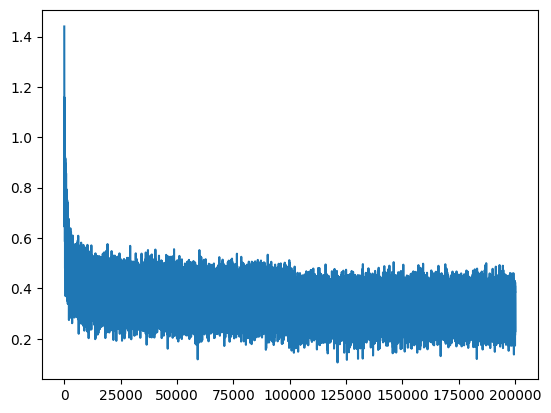

In [11]:
plt.plot(steps, log_loss)

In [12]:
# loss on a whole training set
embedings = C[X_train]             
hidden_layer = torch.tanh(embedings.view(-1, dim * context_length) @ weights1 + bias1)
logits = hidden_layer @ weights2 + bias2    
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.1224, grad_fn=<NllLossBackward0>)

In [13]:
# loss on a dev set
embedings = C[X_dev]             
hidden_layer = torch.tanh(embedings.view(-1, dim * context_length) @ weights1 + bias1)
logits = hidden_layer @ weights2 + bias2    
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1575, grad_fn=<NllLossBackward0>)

In [111]:
# sample from the model
g =torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * context_length                                          # initialize with all ...
    while True:
        embedings = C[torch.tensor([context])]                              # (1, context_length, dimensions)
        hidden_layer = torch.tanh(embedings.view(1, -1) @ weights1 + bias1)       # (1, context_length * dimensions)
        logits = hidden_layer @ weights2 + bias2                            # (1, 27)
        probs = F.softmax(logits, dim=1)
        index = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [index]
        out.append(index)
        if index == 0:
            break
    
    print(''.join(itos[i] for i in out))

cer.
mariah.
makila.
kayden.
mairi.
tainella.
kaman.
arreezyau.
javer.
iot.
simi.
jelina.
jazzied.
akariana.
sadel.
akain.
rylynnse.
hunithavta.
las.
kaspe.


torch.Size([1, 27])